# Introduction to DeepSphere

#### DeepSphere is a spherical graph-based Convolutional Neural Network employing HEALPix sampling.
#### You can also find more examples in https://github.com/deepsphere/deepsphere-cosmo-tf2.
#### In this introduction, we present an estimator for cosmological parameters derived from full-sky matter density maps using DeepSphere. The training data consists of FLASK maps, and the testing is performed on T17 maps generated through N-body simulations. DeepSphere is trained with a minimum NSIDE value of 32 for simplicity. The Mean Squared Error (MSE) loss function is employed during training.
#### Additionally, we extract and visualize the filter weights used in the model. The content of this notebook aligns with Figure 10.1 in my thesis.

In [15]:
%matplotlib inline
import os
os.chdir("/home/r/R.Kanaki/Masterarbeit/מייַ_2023/prior_consideration")
import healpy as heal
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from healpy_networks_custom import HealpyGCNN
import healpy_layers_custom as hp_layer
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt
from standard_2D import Standardize_Min_Max_2D, Rescale_MSE_Min_Max_2D
import build_model
from Loss_mean import MyLoss
from livelossplot import PlotLossesKeras
from cov_by_hand import cov, chisq
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 3 Logical GPUs


## Part 1. Loading and Preprocessing the Data
#### We use Gaussian maps for the training and validation sets and convergence maps from the N-body simulation (T17) for the test data sets.
#### Each map has an angular resolution of NSIDE=32.
#### There are 1000 cosmologies (differing in $\sigma_8$ and $\Omega_m$), with 10 random realizations for the training and validation data sets.
#### We also have 1 fiducial cosmology with 108 realizations for the test data sets.

In [16]:
training_data   = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Hirosaki_universe/prior/Kappa_Field/train_Gauss_1000_10.npz')
testing_data    = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/bin34/T17_downgraded_to_32.npz')

In [17]:
train_data            = training_data['lognormal_map']
test_data             = testing_data['lognormal_map']
train_label_Omega_M       = training_data['Omega_M']
train_label_sigma_8       = training_data['sigma_8']
test_label_Omega_M        = testing_data['Omega_M']
test_label_sigma_8        = testing_data['sigma_8']

#### Training data looks like this!

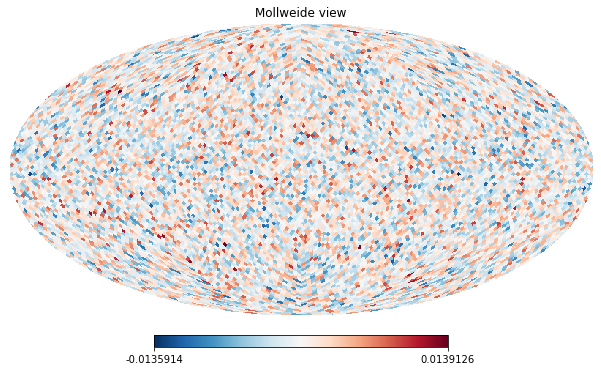

In [18]:
cmin = np.min(train_data[1])
cmax = np.max(train_data[1])
cm = plt.cm.RdBu_r
heal.mollview(train_data[1], cmap=cm,nest=True, min=cmin, max=cmax)

In [6]:
fiducial_Omega_M=test_label_Omega_M[0]
fiducial_sigma_8=test_label_sigma_8[0]

In [7]:
train_labels      = np.zeros((10000,2))
test_labels       = np.zeros((108,2))
for i in range(len(train_label_Omega_M)):
    train_labels[i]=np.array((train_label_Omega_M[i], train_label_sigma_8[i]))
for i in range(len(test_label_Omega_M)):
    test_labels[i]=np.array((test_label_Omega_M[i], test_label_sigma_8[i]))

In [8]:
x_train      = train_data.astype(np.float32)[..., None]
x_test       = test_data.astype(np.float32)[...,None]
np.random.RandomState(11).shuffle(x_train)
labels_train=train_labels.astype(np.float32)
np.random.RandomState(11).shuffle(labels_train)
labels_test=test_labels.astype(np.float32)

#### The training data is sampled using Latin Hypercube sampling in parameter space.
#### Actually not good to use validation split, it destroys LHS sampling, but who cares in 2D.
#### Make plot and check where is our fiducial cosmology.

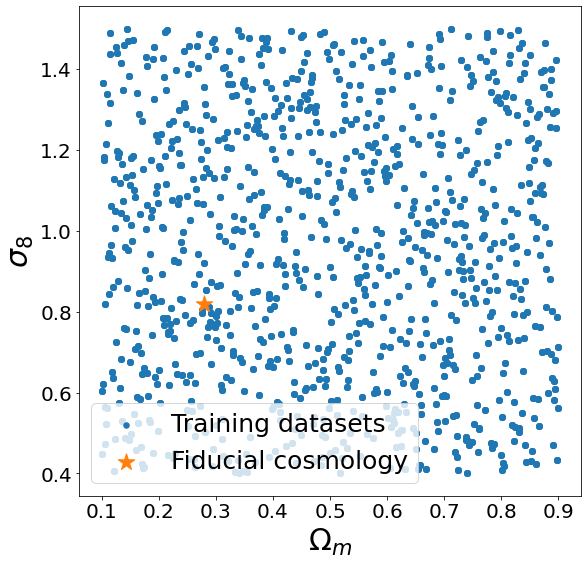

In [19]:
plt.figure(figsize=(9,9))
plt.scatter(train_label_Omega_M, train_label_sigma_8, s=30,label="Training datasets")
plt.scatter(fiducial_Omega_M, fiducial_sigma_8,marker='*', s=300, label="Fiducial cosmology")
plt.xlabel("$\Omega_m$", fontsize=30)
plt.ylabel("$\sigma_8$", fontsize=30)
plt.legend(fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show();

## Part 2. Training GCNN

#### The DeepSphere model can be constructed using the keras.Sequential() method.

In [10]:
nside=32
npix = heal.nside2npix(nside)
indices = np.arange(npix)

In [11]:
layers =[hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=False, use_bn=True,          #1
                                       activation="relu", kernel_regularizer=None),
                  hp_layer.HealpyPool(p=1),                                          #2
                  hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=False, use_bn=True, #3
                                       activation="relu", kernel_regularizer=None),
                  hp_layer.HealpyPool(p=1),                                          #4
                  hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=False, use_bn=True, #5
                                       activation="relu", kernel_regularizer=None),
                  hp_layer.HealpyPool(p=1),                                          #6   
                  hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=False, use_bn=True, #7
                                       activation="relu", kernel_regularizer=None),
                  hp_layer.HealpyPool(p=1),                                          #8   
                  hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=False, use_bn=True, #9
                                       activation="relu", kernel_regularizer=None),  
                  tf.keras.layers.Flatten(),                                         #10
                  tf.keras.layers.Dense(2,use_bias=False)]                           #11
model_MSE = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)      
model_MSE.build(input_shape=(None, len(indices), 1)) 
model_MSE.summary()

Detected a reduction factor of 16.0, the input with nside 32 will be transformed to 2 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: "healpy_gcnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 chebyshev (Chebyshev)       (None, 12288, 5)          60        
                                                                 
 healpy_pool (HealpyPool)    (None, 3072, 5)           0         
                                                                 
 chebyshev_1 (Chebyshev)     (None, 3072, 5)           260       
                                                                 
 healpy_pool_1 (HealpyPool)  (None, 768, 5)            0         
                                                                 
 chebyshev_2 (Chebyshev)     (None, 768, 5)            260       
                                                                 
 healpy_

#### In the first layer, you can see 12288, which corresponds to the number of pixels for NSIDE=32, i.e., 12 x 32 x 32 = 12288.
#### The Chebyshev layer is the graph version of a convolutional layer.
#### F_out represents the number of outputs.
#### K corresponds to the order of the Chebyshev polynomial and also the number of nearest neighbors (K-nearest neighbors).
#### A higher K value provides more accuracy but comes at the cost of increased computational expenses.
#### In the pooling layer, you can observe that the dimensions are divided by 4.

In [12]:
path_MSE='callbacks/Compare_loss'
callbacks_MSE = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_MSE,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)

#### Here, we use the Mean Squared Error (MSE) loss function, which is a typical loss function for regression problems.
$$
loss=\frac{1}{N_s-1}\sum^{N_s}_{i=1}(\theta-\theta_{true})^2
$$
#### where $\theta$ is parameter of model, $\theta_{true}$ is the number of simulation.

In [13]:
model_MSE.compile(optimizer=tf.keras.optimizers.Adam(0.0004),
              loss="mean_squared_error",
              metrics=[tf.keras.metrics.MeanSquaredError()],
)

In [14]:
history_MSE = model_MSE.fit(
    x_train,
    labels_train,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=[callbacks_MSE])

Epoch 1/100
250/250 [==============================] - 7s 14ms/step - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.0507 - val_mean_squared_error: 0.0507
Epoch 2/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 0.0418 - val_mean_squared_error: 0.0418
Epoch 3/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0371 - val_mean_squared_error: 0.0371
Epoch 4/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0394 - mean_squared_error: 0.0394 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 5/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0387 - mean_squared_error: 0.0387 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 6/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - val_loss: 0.0321 - val_mean_squared_error: 0.0321
Epoch 7/100
250/

#### Loss functions

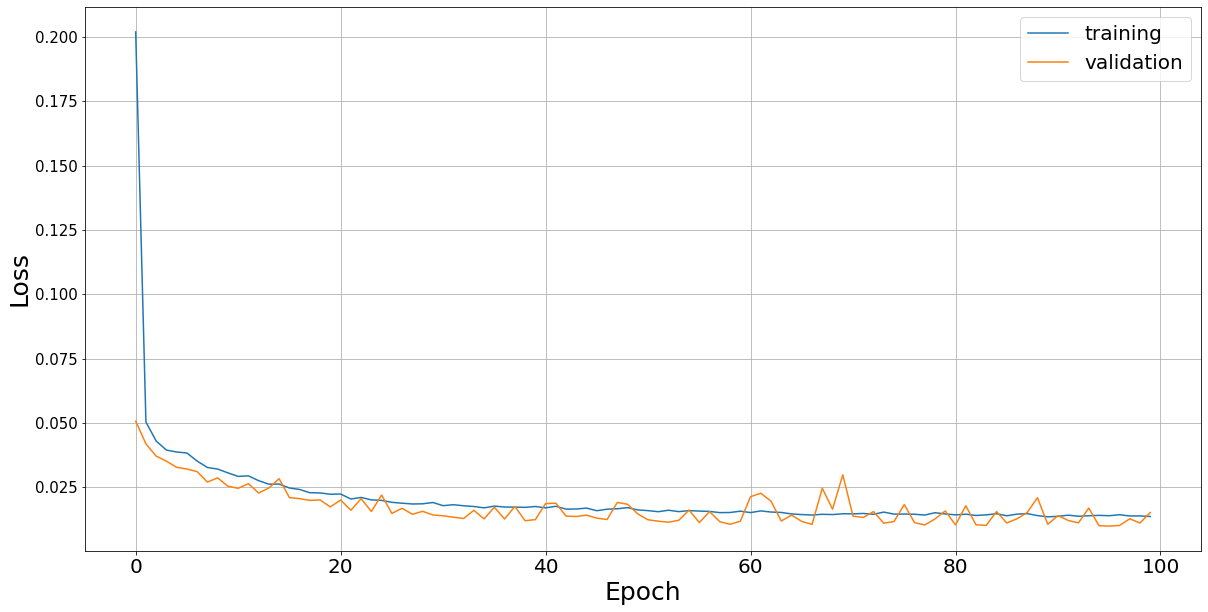

In [22]:
plt.figure(figsize=(20,10))
plt.plot(history_MSE.history["loss"], label="training")
plt.plot(history_MSE.history["val_loss"], label="validation")
plt.grid()
plt.legend(fontsize=20)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("Loss",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xticks(range(10, len(history.history["loss"])), fontsize=15)
plt.yticks(fontsize=15);

#### Ok it is overfitting nice!

## Part 3 Test evaluation

In [24]:
prediction_MSE=model_MSE.predict(test_data)
Omega_M_MSE_MSE = 1. / len(prediction_MSE[:,0]) * np.sum((labels_test[:,0]-prediction_MSE[:,0])**2)
sigma_8_MSE_MSE = 1. / len(prediction_MSE[:,1]) * np.sum((labels_test[:,1]-prediction_MSE[:,1])**2)
print("MSE loss using MSE")
print("$\Omega_m$:", Omega_M_MSE_MSE)
print("$\sigma_8$:", sigma_8_MSE_MSE)

MSE loss using MSE
$\Omega_m$: 0.006041598540765267
$\sigma_8$: 0.04698606332143147


In [25]:
prediction_train = model_MSE.predict(train_data)

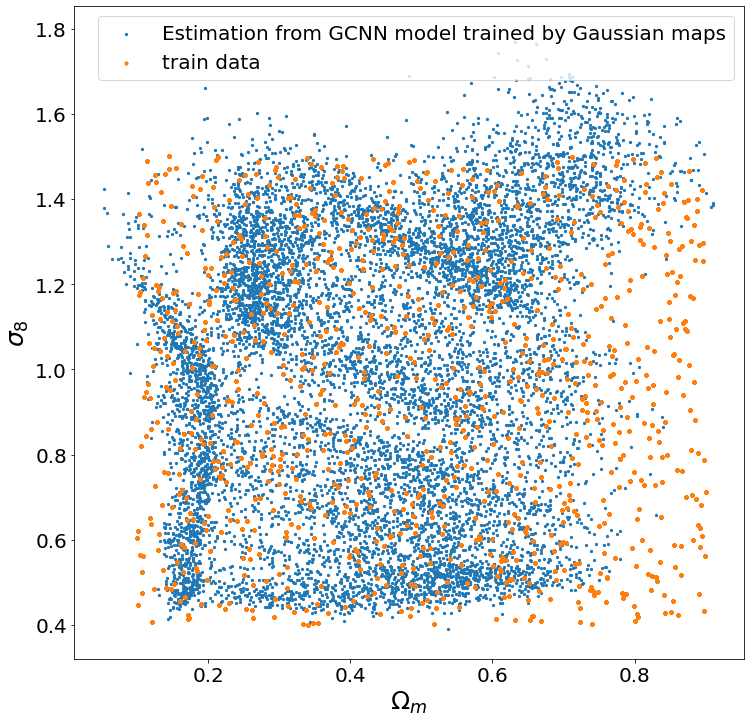

In [29]:
plt.figure(figsize=(12,12))
plt.scatter(prediction_train[:,0],prediction_train[:,1], label=f'Estimation from GCNN model trained by Gaussian maps',s=5)
plt.scatter(train_label_Omega_M, train_label_sigma_8, s=10,label="train data")
plt.legend(fontsize=20)
plt.ylabel(f"$\sigma_8$", fontsize=25)
plt.xlabel(f"$\Omega_m$", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

#### You can observe the pattern, which indicates that this model is biased...

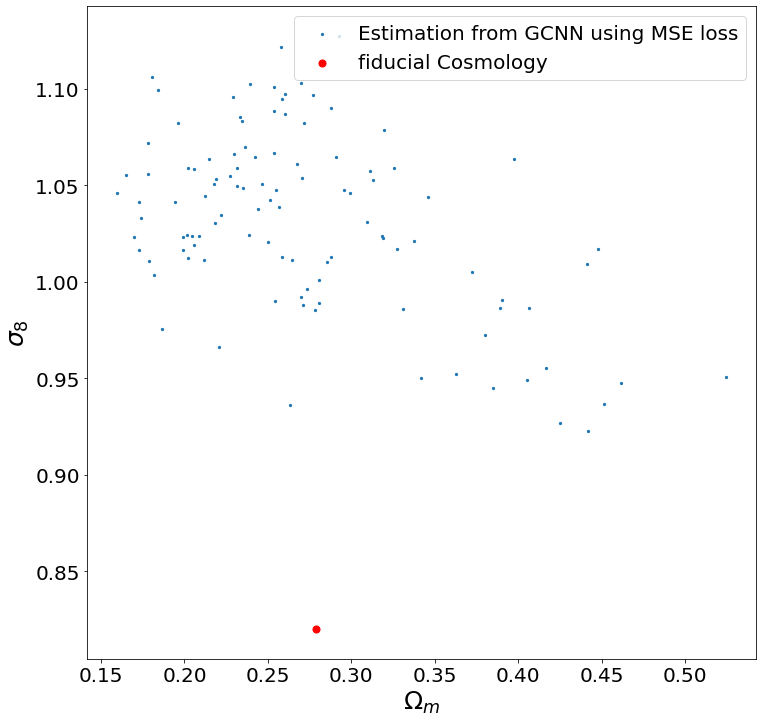

In [30]:
plt.figure(figsize=(12,12))
plt.scatter(prediction_MSE[:,0],prediction_MSE[:,1], label=f'Estimation from GCNN using MSE loss',s=5)
#plt.scatter(prediction_NLL[:,0],prediction_NLL[:,1], label=f'Estimation from GCNN using NLL loss',s=5)
plt.scatter(fiducial_Omega_M, fiducial_sigma_8, label='fiducial Cosmology', s=50, color="red")
plt.legend(fontsize=20)
plt.ylabel(f"$\sigma_8$", fontsize=25)
plt.xlabel(f"$\Omega_m$", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

#### You see..., it is biased!
#### 1. Maybe non-Gaussianity is still important even at NSIDE=128? Is it natural to expect bias when we use T17 as test data?
#### 2. Maybe the machine learning model performed poorly, and the choice of test data doesn't matter?

## Part 4. Covariance(狂分散)
#### Even with MSE, we can obtain parameter covariance using data points cloud!
#### Sample Covariance 
$$
C_{i,j}=\frac{1}{N_s-1}\sum^{N_s}_{s=1}(\theta-\langle\theta\rangle)^T(\theta-\langle\theta\rangle)
$$
#### where $N_s$ is the number of simulation.

In [31]:
mu_MSE   = np.array((np.mean(prediction_MSE[:,0]),np.mean(prediction_MSE[:,1]))).T
cov_MSE  = cov(mu_MSE, prediction_MSE)

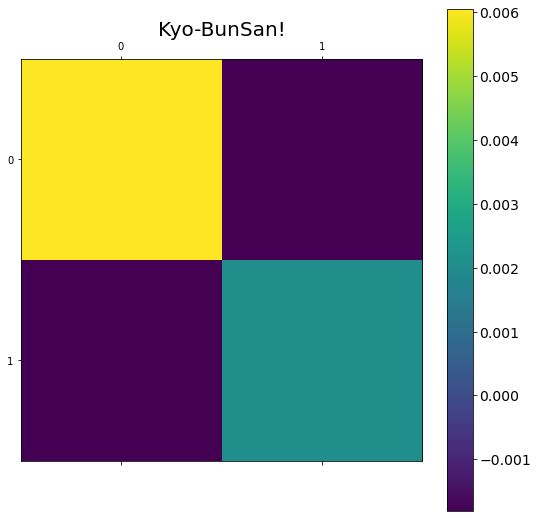

In [35]:
f = plt.figure(figsize=(9,9))
plt.matshow(cov_MSE, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Kyo-BunSan!', fontsize=20);

#### Kovarianz, guck mal Kovarianz! 

## Part 4 Plot Posterior
#### We plot the posterior distribution which you can use for Yugioh Duel!

In [37]:
ndim         = 2
nsamp        = 1000000
random_state = np.random.default_rng(10)
samps_MSE    = random_state.multivariate_normal(mu_MSE, cov_MSE, size=nsamp)

In [45]:
param_names = ['\Omega_m', '\sigma_8']
samples_MSE = MCSamples(samples=samps_MSE, names=param_names, labels=param_names, label='GCNN MSE')

Removed no burn in


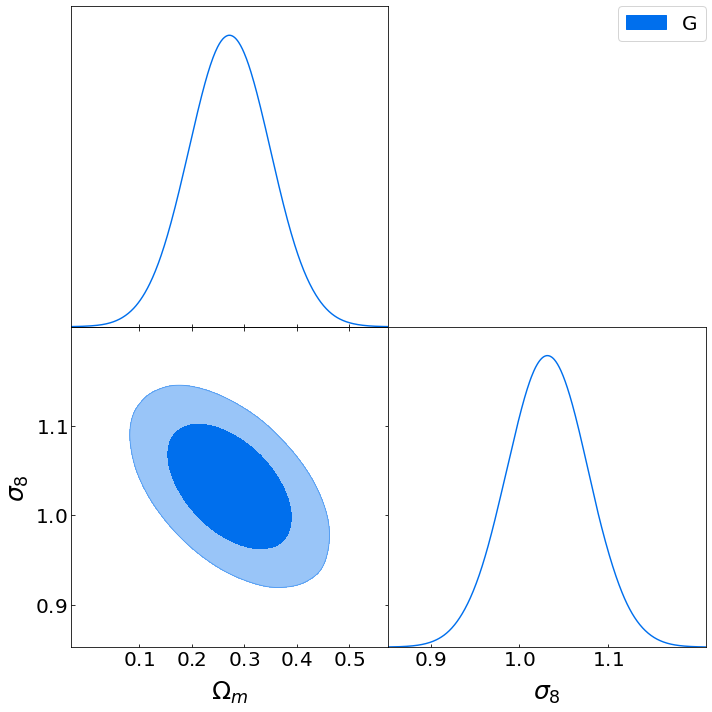

In [50]:
g = plots.get_subplot_plotter(width_inch=10)
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 25
g.settings.legend_fontsize = 20
g.triangle_plot(samples_MSE, filled=True, legend_labels='GCNN MSE', legend_loc='upper right')
g.subplots[1, 0].plot([fiducial_Omega_M], [fiducial_sigma_8], marker='*', label='Fiducial Cosmology', markersize=15, color="black")
plt.show();

#### It is so biased, and so far from fiducial point....

## Part 5 Filter Interpretation

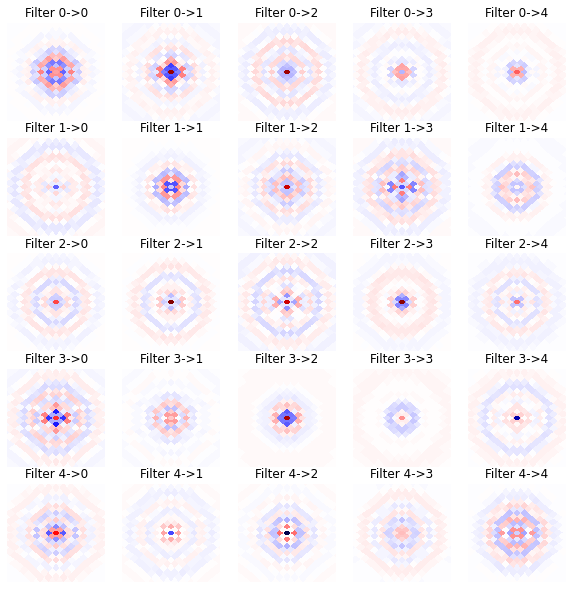

In [56]:
figs = model_MSE.plot_filters_gnomonic(2)

#### Wow here is learned weight, spherical symmetric.
#### But it is same for me like the pictures in Brandthorst museum.
#### I need more clever idea to get use this somehow statistically!